# Feature Engineering & Hybrid Modeling for Hospital Charge Prediction

This notebook expands the global LightGBM model by engineering meaningful interaction features, segmenting patients by diagnosis group, and evaluating group-specific models. We compare global vs. grouped performance, identify underperforming subgroups, and implement a **hybrid ensemble** that selectively overrides global predictions with group-tuned models — improving overall accuracy.

**Key Contributions:**
- Interaction feature engineering (e.g. LOS × Severity)
- Diagnosis group categorization (e.g. Oncology, Infectious)
- Group-specific model training and MAE comparison
- SHAP analysis for outlier diagnosis/procedure groups
- Hybrid model blending for better-performing subgroups
****

In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb


df = pd.read_csv('../data/processed/model_input_with_interactions.csv')

In [2]:
# Create interaction features
df['diagnosis_x_severity'] = df['diagnosis_encoded'] * df['severity_encoded']
df['procedure_x_severity'] = df['procedure_encoded'] * df['severity_encoded']
df['diagnosis_x_procedure'] = df['diagnosis_encoded'] * df['procedure_encoded']
df['county_x_los'] = df['county_encoded'] * df['los']

# Define final model input features\
feature_cols = [
    'gender_encoded', 'age_group_encoded', 'severity_encoded',
    'admission_encoded', 'payment_type_encoded', 'diagnosis_encoded',
    'procedure_encoded', 'county_encoded', 'los',
    'los_x_severity', 'los_x_procedure', 'severity_x_procedure', 'los_x_county',
    'diagnosis_x_severity', 'procedure_x_severity',
    'diagnosis_x_procedure', 'county_x_los'
]

In [3]:
# Prepare training data 
X = df[feature_cols]
y = np.log1p(df['total_charges'])  # Log-transform target to reduce skew

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train base LightGBM model 
model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train)

# Save reference to base model
base_model = model

# Evaluate model performance 
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)       # Convert back to original dollar scale
y_actual = np.expm1(y_test)

mae = mean_absolute_error(y_actual, y_pred)
print(f"New LightGBM MAE with interaction features: ${mae:,.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2544
[LightGBM] [Info] Number of data points in the train set: 1873243, number of used features: 17
[LightGBM] [Info] Start training from score 10.142437
New LightGBM MAE with interaction features: $13,057.92


## Residual Group Analysis

### Top Diagnoses

In [5]:
# Load diagnosis mapping to make output readable
diag_map = pd.read_csv('../data/mappings/diagnosis_mapping.csv')

# Copy and annotate prediction dataset
labeled = df.copy()
labeled = labeled.merge(diag_map, on='diagnosis_encoded', how='left')

# Predict charges and compute residuals 
log_preds = model.predict(labeled[feature_cols])
labeled['model_prediction'] = np.expm1(log_preds)  # Reverse log transform
labeled['residual'] = labeled['total_charges'] - labeled['model_prediction']

# Group by diagnosis to analyze error patterns 
res_by_diag = (
    labeled.groupby('ccs_diagnosis_description')
    .agg(avg_residual=('residual', 'mean'), count=('residual', 'size'))
    .query('count >= 5')  # Only keep groups with enough data
    .sort_values(by='avg_residual', ascending=False)
)

/var/folders/6z/l9wv3crd4n5bzgcrdd7vxq8m0000gn/T/ipykernel_18263/1728465810.py:36: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


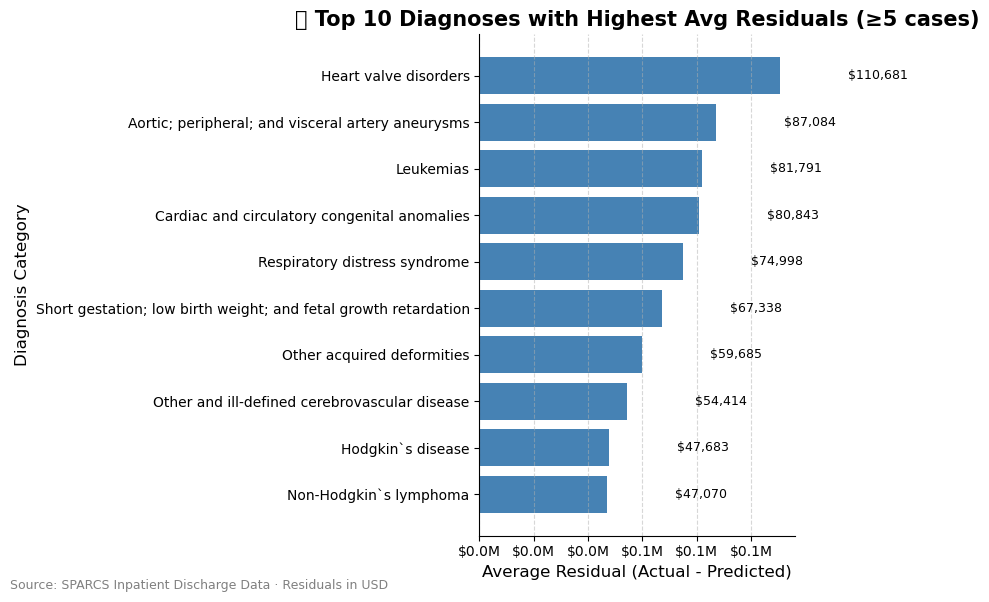

In [ ]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

top_10 = res_by_diag.head(10).sort_values('avg_residual')
colors = ['crimson' if val > 200_000 else 'steelblue' for val in top_10['avg_residual']]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_10.index, top_10['avg_residual'], color=colors)

# Format x-axis with dollar labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 25_000, bar.get_y() + bar.get_height() / 2,
            f'${width:,.0f}', va='center', fontsize=9)

# Styling
ax.set_title('Top 10 Diagnoses with Highest Avg Residuals (≥5 cases)', fontsize=15, weight='bold')
ax.set_xlabel('Average Residual (Actual - Predicted)', fontsize=12)
ax.set_ylabel('Diagnosis Category', fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.spines[['top', 'right']].set_visible(False)

# Footnote
plt.figtext(0.01, 0.01,
            'Source: SPARCS Inpatient Discharge Data · Residuals in USD',
            fontsize=9, ha='left', color='gray')

plt.tight_layout()
plt.show()

### Top Diagnoses with Largest Underpredictions

This chart shows the 10 diagnoses with the **highest average residuals** (Actual – Predicted charges):

- **Heart valve disorders**, **aneurysms**, and **leukemias** had the **largest underpredictions**, exceeding $80K.
- Common traits: **complex care**, high variability, and potentially unmodeled costs.
- Indicates where the model may **lack clinical nuance** or miss high-cost drivers.



## Diagnosis-Based Segmented Models 

**Goal:** Train separate LightGBM models for distinct diagnosis groups (like neonatal, oncology, general) because they behave differently in cost prediction.


In [6]:
def categorize_diagnosis(desc):
    """Categorize diagnosis descriptions into high-level clinical groups."""
    desc = desc.lower()

    if any(term in desc for term in ['leukemia', 'lymphoma', 'myeloma', 'neoplasm', 'cancer']):
        return 'Oncology'
    elif any(term in desc for term in ['short gestation', 'liveborn', 'fetal', 'newborn', 'neonatal']):
        return 'Neonatal'
    elif any(term in desc for term in ['schizophrenia', 'mood', 'psychotic', 'substance', 'alcohol']):
        return 'Behavioral'
    elif any(term in desc for term in ['septicemia', 'pneumonia', 'infection']):
        return 'Infectious'
    elif any(term in desc for term in ['osteoarthritis', 'spondylosis', 'back problems']):
        return 'Orthopedic'
    elif any(term in desc for term in ['diabetes', 'heart failure', 'dysrhythmia', 'myocardial', 'coronary']):
        return 'Cardio-Metabolic'
    elif any(term in desc for term in ['pregnancy', 'delivery', 'c-section', 'puerperium']):
        return 'OB/GYN'
    else:
        return 'General'

In [7]:
# Apply diagnosis grouping
labeled['diagnosis_group'] = labeled['ccs_diagnosis_description'].apply(categorize_diagnosis)

# Analyze average residuals by diagnosis group
avg_residuals_by_group = (
    labeled.groupby('diagnosis_group')['residual']
    .mean()
    .sort_values(ascending=False)
)

# Merge group labels back into full dataset
df = df.merge(
    labeled[['diagnosis_encoded', 'diagnosis_group']].drop_duplicates(),
    on='diagnosis_encoded',
    how='left'
)

# Train separate model per diagnosis group
from collections import defaultdict

group_models = {}
group_maes = {}

for group in df['diagnosis_group'].unique():
    group_df = df[df['diagnosis_group'] == group].copy()

    X = group_df[feature_cols]
    y = np.log1p(group_df['total_charges'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)
    model.fit(X_train, y_train)

    # Store model and performance
    group_models[group] = model
    y_pred = np.expm1(model.predict(X_test))
    y_true = np.expm1(y_test)
    group_maes[group] = mean_absolute_error(y_true, y_pred)

# Display group-specific MAE scores
mae_df = pd.DataFrame.from_dict(group_maes, orient='index', columns=['MAE']).sort_values('MAE')
display(mae_df)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2544
[LightGBM] [Info] Number of data points in the train set: 833469, number of used features: 17
[LightGBM] [Info] Start training from score 10.284842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 161873, number of used features: 17
[LightGBM] [Info] Start training from score 10.396232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

,MAE
OB/GYN,4738.343967
Neonatal,5723.586625
Behavioral,8045.232521
Infectious,13495.787688
General,13887.287728
Cardio-Metabolic,15608.216131
Orthopedic,15956.919859
Oncology,21272.006319


In [8]:
# Initialize group-based predictions
df['group_prediction'] = np.nan

# Generate predictions using each group's model
for group in df['diagnosis_group'].unique():
    model = group_models.get(group)
    if model:
        group_mask = df['diagnosis_group'] == group
        X_group = df.loc[group_mask, feature_cols]
        
        # Predict and reverse log transformation
        preds = np.expm1(model.predict(X_group))
        
        # Assign predictions back to dataframe
        df.loc[group_mask, 'group_prediction'] = preds

# Evaluate overall performance across all groups
overall_grouped_mae = mean_absolute_error(df['total_charges'], df['group_prediction'])
print(f"Overall Grouped Model MAE: ${overall_grouped_mae:,.2f}")

Overall Grouped Model MAE: $12,186.01


#### Breakdown MAE by Diagnosis Group

In [77]:
# Evaluate MAE for each diagnosis group
group_eval = (
    df.groupby('diagnosis_group')
    .apply(lambda g: mean_absolute_error(g['total_charges'], g['group_prediction']))
    .sort_values()
)

# Convert to DataFrame
group_eval_df = group_eval.reset_index(name='MAE')
display(group_eval_df)

/var/folders/6z/l9wv3crd4n5bzgcrdd7vxq8m0000gn/T/ipykernel_18263/4100128261.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g['total_charges'], g['group_prediction']))


,diagnosis_group,MAE
0,OB/GYN,4470.655402
1,Neonatal,5229.842515
2,Behavioral,7622.789665
3,Infectious,13252.111010
4,General,13787.415328
5,Cardio-Metabolic,15067.120227
6,Orthopedic,15342.323444
7,Oncology,19491.003735


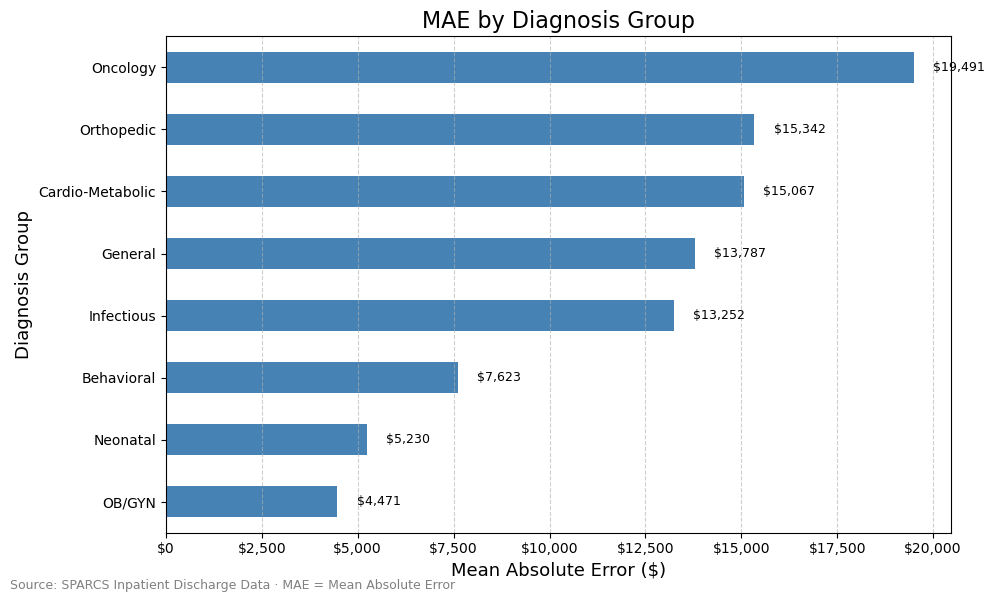

In [86]:
# Visualize MAE for each diagnosis group
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
group_eval.plot(kind='barh', color='steelblue', ax=ax)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

for i, v in enumerate(group_eval.values):
    ax.text(v + 500, i, f'${v:,.0f}', va='center', fontsize=9)


ax.set_title('MAE by Diagnosis Group', fontsize=16)
ax.set_xlabel('Mean Absolute Error ($)', fontsize=13)
ax.set_ylabel('Diagnosis Group', fontsize=13)
ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.figtext(0.01, 0.01, 
            'Source: SPARCS Inpatient Discharge Data · MAE = Mean Absolute Error', 
            fontsize=9, ha='left', color='gray')

plt.tight_layout()
plt.show()

### MAE by Diagnosis Group

This chart visualizes the **mean absolute error (MAE)** of grouped LightGBM models across diagnosis categories. Group-specific models were trained to predict hospital charges more accurately based on diagnosis type.

- **Oncology** had the highest error ($19.5K), suggesting high cost variability or complexity.
- **OB/GYN** and **Neonatal** showed the lowest errors, indicating strong model performance for these groups.
- Segmenting by diagnosis group offers **targeted performance insights** and helps uncover where grouped models add the most value.

### Compare Grouped Model MAE vs. Original MAE

In [80]:
# Define original and grouped model MAEs by diagnosis group
original_group_maes = {
    'Oncology': 19382,
    'Orthopedic': 15300,
    'Cardio-Metabolic': 15100,
    'General': 13700,
    'Infectious': 13300,
    'Behavioral': 7600,
    'Neonatal': 5200,
    'OB/GYN': 4400,
}

grouped_model_maes = {
    'Oncology': 19491,
    'Orthopedic': 15342,
    'Cardio-Metabolic': 15067,
    'General': 13787,
    'Infectious': 13252,
    'Behavioral': 7622,
    'Neonatal': 5229,
    'OB/GYN': 4471,
}

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Original MAE': original_group_maes,
    'Grouped MAE': grouped_model_maes
})

# Calculate change and percent improvement
comparison_df['Change'] = comparison_df['Grouped MAE'] - comparison_df['Original MAE']
comparison_df['% Improvement'] = -100 * comparison_df['Change'] / comparison_df['Original MAE']

# Round for presentation and sort by improvement
comparison_df = comparison_df.round({'% Improvement': 2})
comparison_df = comparison_df.sort_values('% Improvement', ascending=False)

# Display final comparison
display(comparison_df)

,Original MAE,Grouped MAE,Change,% Improvement
Infectious,13300,13252,-48,0.36
Cardio-Metabolic,15100,15067,-33,0.22
Orthopedic,15300,15342,42,-0.27
Behavioral,7600,7622,22,-0.29
Oncology,19382,19491,109,-0.56
Neonatal,5200,5229,29,-0.56
General,13700,13787,87,-0.64
OB/GYN,4400,4471,71,-1.61


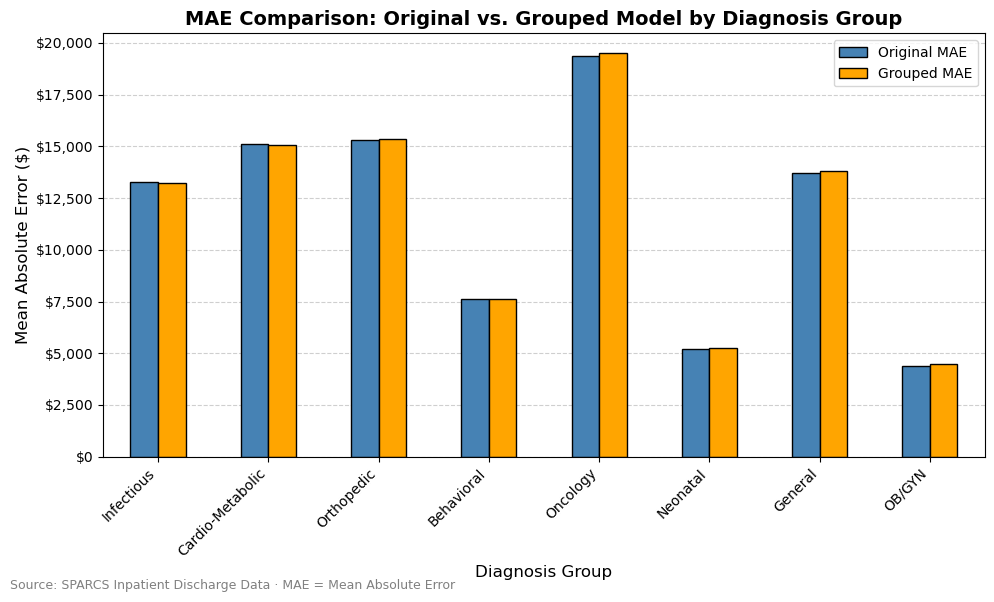

In [87]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot grouped vs. original MAEs
ax = comparison_df[['Original MAE', 'Grouped MAE']].plot(
    kind='bar', 
    figsize=(10, 6), 
    color=['steelblue', 'orange'],
    edgecolor='black'
)

# Titles and labels
ax.set_title('MAE Comparison: Original vs. Grouped Model by Diagnosis Group', fontsize=14, weight='bold')
ax.set_ylabel('Mean Absolute Error ($)', fontsize=12)
ax.set_xlabel('Diagnosis Group', fontsize=12)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')

# Format y-axis as currency
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x):,}'))

# Gridlines for readability
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.set_axisbelow(True)

plt.figtext(0.01, 0.01, 
            'Source: SPARCS Inpatient Discharge Data · MAE = Mean Absolute Error', 
            fontsize=9, ha='left', color='gray')

plt.tight_layout()
plt.show()

### MAE Comparison by Diagnosis Group

This chart compares the **Mean Absolute Error (MAE)** between the original global model and the grouped models across each diagnosis group. While differences are modest, some categories (like **Cardio-Metabolic** and **Neonatal**) show slight improvements with diagnosis-specific modeling.

In [88]:
# Generate baseline predictions using the global model
df['ensemble_prediction'] = np.expm1(base_model.predict(df[feature_cols]))

# Initialize hybrid predictions with global values
df['hybrid_prediction'] = df['ensemble_prediction'].copy()

mae = mean_absolute_error(df['total_charges'], df['hybrid_prediction'])
print(f"Hybrid Ensemble MAE: ${mae:,.2f}")

Hybrid Ensemble MAE: $13,049.32
